# Transfer predictions from NAGuideR

In [1]:
from pathlib import Path
import logging
import pandas as pd
import matplotlib.pyplot as plt

import vaep
import vaep.models
from vaep.io import datasplits
import vaep.pandas

vaep.plotting.make_large_descriptors(5)

logger = vaep.logging.setup_logger(logging.getLogger('vaep'))

In [2]:
# catch passed parameters
args = None
args = dict(globals()).keys()

Papermill script parameters:

In [3]:
# files and folders
# Datasplit folder with data for experiment
folder_experiment: str = 'runs/example'
folder_data: str = ''  # specify data directory if needed
file_format: str = 'csv'  # file format of create splits, default pickle (csv)
identifer_str: str = '_all_'  # identifier for prediction files to be filtered
dumps: list = None  # list of dumps to be used

In [4]:
# Parameters
dumps = "runs/dev_dataset_small/proteinGroups_N50/preds/pred_all_BPCA.csv,runs/dev_dataset_small/proteinGroups_N50/preds/pred_all_COLMEDIAN.csv,runs/dev_dataset_small/proteinGroups_N50/preds/pred_all_IMPSEQ.csv,runs/dev_dataset_small/proteinGroups_N50/preds/pred_all_IMPSEQROB.csv,runs/dev_dataset_small/proteinGroups_N50/preds/pred_all_IRM.csv,runs/dev_dataset_small/proteinGroups_N50/preds/pred_all_KNN_IMPUTE.csv,runs/dev_dataset_small/proteinGroups_N50/preds/pred_all_LLS.csv,runs/dev_dataset_small/proteinGroups_N50/preds/pred_all_MICE-CART.csv,runs/dev_dataset_small/proteinGroups_N50/preds/pred_all_MICE-NORM.csv,runs/dev_dataset_small/proteinGroups_N50/preds/pred_all_MINDET.csv,runs/dev_dataset_small/proteinGroups_N50/preds/pred_all_MINIMUM.csv,runs/dev_dataset_small/proteinGroups_N50/preds/pred_all_MINPROB.csv,runs/dev_dataset_small/proteinGroups_N50/preds/pred_all_MLE.csv,runs/dev_dataset_small/proteinGroups_N50/preds/pred_all_MSIMPUTE.csv,runs/dev_dataset_small/proteinGroups_N50/preds/pred_all_PI.csv,runs/dev_dataset_small/proteinGroups_N50/preds/pred_all_QRILC.csv,runs/dev_dataset_small/proteinGroups_N50/preds/pred_all_RF.csv,runs/dev_dataset_small/proteinGroups_N50/preds/pred_all_ROWMEDIAN.csv,runs/dev_dataset_small/proteinGroups_N50/preds/pred_all_SEQKNN.csv,runs/dev_dataset_small/proteinGroups_N50/preds/pred_all_SVDMETHOD.csv,runs/dev_dataset_small/proteinGroups_N50/preds/pred_all_TRKNN.csv,runs/dev_dataset_small/proteinGroups_N50/preds/pred_all_ZERO.csv"
folder_experiment = "runs/dev_dataset_small/proteinGroups_N50"


Some argument transformations

In [5]:
args = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.args_from_dict(args)
args

{'data': Path('runs/dev_dataset_small/proteinGroups_N50/data'),
 'dumps': 'runs/dev_dataset_small/proteinGroups_N50/preds/pred_all_BPCA.csv,runs/dev_dataset_small/proteinGroups_N50/preds/pred_all_COLMEDIAN.csv,runs/dev_dataset_small/proteinGroups_N50/preds/pred_all_IMPSEQ.csv,runs/dev_dataset_small/proteinGroups_N50/preds/pred_all_IMPSEQROB.csv,runs/dev_dataset_small/proteinGroups_N50/preds/pred_all_IRM.csv,runs/dev_dataset_small/proteinGroups_N50/preds/pred_all_KNN_IMPUTE.csv,runs/dev_dataset_small/proteinGroups_N50/preds/pred_all_LLS.csv,runs/dev_dataset_small/proteinGroups_N50/preds/pred_all_MICE-CART.csv,runs/dev_dataset_small/proteinGroups_N50/preds/pred_all_MICE-NORM.csv,runs/dev_dataset_small/proteinGroups_N50/preds/pred_all_MINDET.csv,runs/dev_dataset_small/proteinGroups_N50/preds/pred_all_MINIMUM.csv,runs/dev_dataset_small/proteinGroups_N50/preds/pred_all_MINPROB.csv,runs/dev_dataset_small/proteinGroups_N50/preds/pred_all_MLE.csv,runs/dev_dataset_small/proteinGroups_N50/preds/

In [6]:
files_out = {}

load data splits

In [7]:
data = datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/dev_dataset_small/proteinGroups_N50/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/dev_dataset_small/proteinGroups_N50/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/dev_dataset_small/proteinGroups_N50/data/test_y.csv


Validation and test data split of simulated missing values

In [8]:
val_pred_fake_na = data.val_y.to_frame(name='observed')
val_pred_fake_na

,,observed
Sample ID,Gene Names,
2020_01_15_13_56_Q-Exactive-HF-X-Orbitrap_6070,SEH1L,27.180
2020_01_04_10_03_Q-Exactive-HF-X-Orbitrap_6070,SLC9A3R1,30.259
2020_05_20_15_35_Q-Exactive-HF-X-Orbitrap_6070,KYNU,30.629
2020_01_03_11_17_Q-Exactive-HF-X-Orbitrap_6070,ADD3,24.541
2020_02_05_20_55_Q-Exactive-HF-X-Orbitrap_6070,CALM2;CALM1,33.934
...,...,...
2020_05_20_15_35_Q-Exactive-HF-X-Orbitrap_6070,PPP2R4;DKFZp781M17165,28.717
2020_03_11_11_25_Q-Exactive-HF-X-Orbitrap_6070,MED23,24.966
2020_03_07_18_15_Q-Exactive-HF-X-Orbitrap_6070,RBMXL1,26.654


In [9]:
test_pred_fake_na = data.test_y.to_frame(name='observed')
test_pred_fake_na.describe()

,observed
count,"9,327.000"
mean,27.230
std,2.888
min,19.974
25%,24.905
50%,26.929
75%,29.174
max,37.689


In [10]:
# Find and load prediction files, filter for validation and test data

In [11]:
if args.dumps is not None:
    entire_pred = [Path(s) for s in args.dumps.split(',')]
else:
    entire_pred = list(file for file in args.out_preds.iterdir()
                       if '_all_' in str(file))
entire_pred

[Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_all_BPCA.csv'),
 Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_all_COLMEDIAN.csv'),
 Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_all_IMPSEQ.csv'),
 Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_all_IMPSEQROB.csv'),
 Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_all_IRM.csv'),
 Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_all_KNN_IMPUTE.csv'),
 Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_all_LLS.csv'),
 Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_all_MICE-CART.csv'),
 Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_all_MICE-NORM.csv'),
 Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_all_MINDET.csv'),
 Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_all_MINIMUM.csv'),
 Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_all_MINPROB.csv'),
 Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_all_MLE

In [12]:
mask = data.train_X.unstack().isna().stack()
idx_real_na = mask.index[mask]
idx_real_na = (idx_real_na
               .drop(val_pred_fake_na.index)
               .drop(test_pred_fake_na.index))

for fpath in entire_pred:
    logger.info(f"Load {fpath = }")
    col_name = fpath.stem.split('_all_')[-1]
    pred = pd.read_csv(fpath, index_col=[1, 0])
    val_pred_fake_na[col_name] = pred
    fname = args.out_preds / f'pred_val_{col_name}.csv'
    files_out[fname.name] = fname.as_posix()
    val_pred_fake_na[['observed', col_name]].to_csv(fname)
    logger.info(f"Save {fname = }")

    test_pred_fake_na[col_name] = pred
    fname = args.out_preds / f'pred_test_{col_name}.csv'
    files_out[fname.name] = fname.as_posix()
    test_pred_fake_na[['observed', col_name]].to_csv(fname)
    logger.info(f"Save {fname = }")
    # hacky, but works:
    pred_real_na = (pd.Series(0, index=idx_real_na, name='placeholder')
                    .to_frame()
                    .join(pred, how='left')
                    .drop('placeholder', axis=1))
    # pred_real_na.name = 'intensity'
    fname = args.out_preds / f'pred_real_na_{col_name}.csv'
    files_out[fname.name] = fname.as_posix()
    pred_real_na.to_csv(fname)
    logger.info(f"Save {fname = }")

# del pred

vaep - INFO     Load fpath = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_all_BPCA.csv')


vaep - INFO     Save fname = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_val_BPCA.csv')


vaep - INFO     Save fname = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_test_BPCA.csv')


vaep - INFO     Save fname = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_real_na_BPCA.csv')


vaep - INFO     Load fpath = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_all_COLMEDIAN.csv')


vaep - INFO     Save fname = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_val_COLMEDIAN.csv')


vaep - INFO     Save fname = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_test_COLMEDIAN.csv')


vaep - INFO     Save fname = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_real_na_COLMEDIAN.csv')


vaep - INFO     Load fpath = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_all_IMPSEQ.csv')


vaep - INFO     Save fname = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_val_IMPSEQ.csv')


vaep - INFO     Save fname = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_test_IMPSEQ.csv')


vaep - INFO     Save fname = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_real_na_IMPSEQ.csv')


vaep - INFO     Load fpath = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_all_IMPSEQROB.csv')


vaep - INFO     Save fname = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_val_IMPSEQROB.csv')


vaep - INFO     Save fname = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_test_IMPSEQROB.csv')


vaep - INFO     Save fname = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_real_na_IMPSEQROB.csv')


vaep - INFO     Load fpath = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_all_IRM.csv')


vaep - INFO     Save fname = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_val_IRM.csv')


vaep - INFO     Save fname = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_test_IRM.csv')


vaep - INFO     Save fname = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_real_na_IRM.csv')


vaep - INFO     Load fpath = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_all_KNN_IMPUTE.csv')


vaep - INFO     Save fname = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_val_KNN_IMPUTE.csv')


vaep - INFO     Save fname = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_test_KNN_IMPUTE.csv')


vaep - INFO     Save fname = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_real_na_KNN_IMPUTE.csv')


vaep - INFO     Load fpath = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_all_LLS.csv')


vaep - INFO     Save fname = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_val_LLS.csv')


vaep - INFO     Save fname = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_test_LLS.csv')


vaep - INFO     Save fname = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_real_na_LLS.csv')


vaep - INFO     Load fpath = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_all_MICE-CART.csv')


vaep - INFO     Save fname = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_val_MICE-CART.csv')


vaep - INFO     Save fname = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_test_MICE-CART.csv')


vaep - INFO     Save fname = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_real_na_MICE-CART.csv')


vaep - INFO     Load fpath = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_all_MICE-NORM.csv')


vaep - INFO     Save fname = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_val_MICE-NORM.csv')


vaep - INFO     Save fname = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_test_MICE-NORM.csv')


vaep - INFO     Save fname = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_real_na_MICE-NORM.csv')


vaep - INFO     Load fpath = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_all_MINDET.csv')


vaep - INFO     Save fname = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_val_MINDET.csv')


vaep - INFO     Save fname = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_test_MINDET.csv')


vaep - INFO     Save fname = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_real_na_MINDET.csv')


vaep - INFO     Load fpath = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_all_MINIMUM.csv')


vaep - INFO     Save fname = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_val_MINIMUM.csv')


vaep - INFO     Save fname = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_test_MINIMUM.csv')


vaep - INFO     Save fname = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_real_na_MINIMUM.csv')


vaep - INFO     Load fpath = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_all_MINPROB.csv')


vaep - INFO     Save fname = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_val_MINPROB.csv')


vaep - INFO     Save fname = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_test_MINPROB.csv')


vaep - INFO     Save fname = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_real_na_MINPROB.csv')


vaep - INFO     Load fpath = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_all_MLE.csv')


vaep - INFO     Save fname = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_val_MLE.csv')


vaep - INFO     Save fname = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_test_MLE.csv')


vaep - INFO     Save fname = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_real_na_MLE.csv')


vaep - INFO     Load fpath = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_all_MSIMPUTE.csv')


vaep - INFO     Save fname = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_val_MSIMPUTE.csv')


vaep - INFO     Save fname = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_test_MSIMPUTE.csv')


vaep - INFO     Save fname = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_real_na_MSIMPUTE.csv')


vaep - INFO     Load fpath = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_all_PI.csv')


vaep - INFO     Save fname = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_val_PI.csv')


vaep - INFO     Save fname = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_test_PI.csv')


vaep - INFO     Save fname = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_real_na_PI.csv')


vaep - INFO     Load fpath = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_all_QRILC.csv')


vaep - INFO     Save fname = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_val_QRILC.csv')


vaep - INFO     Save fname = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_test_QRILC.csv')


vaep - INFO     Save fname = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_real_na_QRILC.csv')


vaep - INFO     Load fpath = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_all_RF.csv')


vaep - INFO     Save fname = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_val_RF.csv')


vaep - INFO     Save fname = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_test_RF.csv')


vaep - INFO     Save fname = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_real_na_RF.csv')


vaep - INFO     Load fpath = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_all_ROWMEDIAN.csv')


vaep - INFO     Save fname = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_val_ROWMEDIAN.csv')


vaep - INFO     Save fname = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_test_ROWMEDIAN.csv')


vaep - INFO     Save fname = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_real_na_ROWMEDIAN.csv')


vaep - INFO     Load fpath = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_all_SEQKNN.csv')


vaep - INFO     Save fname = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_val_SEQKNN.csv')


vaep - INFO     Save fname = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_test_SEQKNN.csv')


vaep - INFO     Save fname = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_real_na_SEQKNN.csv')


vaep - INFO     Load fpath = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_all_SVDMETHOD.csv')


vaep - INFO     Save fname = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_val_SVDMETHOD.csv')


vaep - INFO     Save fname = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_test_SVDMETHOD.csv')


vaep - INFO     Save fname = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_real_na_SVDMETHOD.csv')


vaep - INFO     Load fpath = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_all_TRKNN.csv')


vaep - INFO     Save fname = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_val_TRKNN.csv')


vaep - INFO     Save fname = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_test_TRKNN.csv')


vaep - INFO     Save fname = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_real_na_TRKNN.csv')


vaep - INFO     Load fpath = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_all_ZERO.csv')


vaep - INFO     Save fname = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_val_ZERO.csv')


vaep - INFO     Save fname = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_test_ZERO.csv')


vaep - INFO     Save fname = Path('runs/dev_dataset_small/proteinGroups_N50/preds/pred_real_na_ZERO.csv')


In [13]:
val_pred_fake_na

,,observed,BPCA,COLMEDIAN,IMPSEQ,IMPSEQROB,IRM,KNN_IMPUTE,LLS,MICE-CART,MICE-NORM,...,MLE,MSIMPUTE,PI,QRILC,RF,ROWMEDIAN,SEQKNN,SVDMETHOD,TRKNN,ZERO
Sample ID,Gene Names,,,,,,,,,,,,,,,,,,,,,
2020_01_15_13_56_Q-Exactive-HF-X-Orbitrap_6070,SEH1L,27.180,26.560,26.936,26.530,"2,489.427",26.097,26.198,26.976,25.002,26.340,...,"2,489.427",26.243,22.486,25.790,26.807,28.397,26.395,27.094,26.818,0
2020_01_04_10_03_Q-Exactive-HF-X-Orbitrap_6070,SLC9A3R1,30.259,28.092,26.764,28.323,"2,655.110",28.198,27.482,27.612,27.842,28.726,...,27.270,26.741,23.483,28.436,28.882,30.188,27.484,27.021,28.079,0
2020_05_20_15_35_Q-Exactive-HF-X-Orbitrap_6070,KYNU,30.629,30.857,27.666,31.074,NaN,31.007,30.769,31.011,31.042,30.953,...,"2,411.950",29.974,23.421,29.235,30.928,30.994,30.890,27.938,30.934,0
2020_01_03_11_17_Q-Exactive-HF-X-Orbitrap_6070,ADD3,24.541,26.012,27.883,26.199,NaN,25.660,25.867,26.651,25.208,26.056,...,31.437,24.470,22.876,22.556,25.950,26.171,26.139,28.211,26.198,0
2020_02_05_20_55_Q-Exactive-HF-X-Orbitrap_6070,CALM2;CALM1,33.934,33.543,28.877,33.720,NaN,34.081,33.929,32.876,33.767,33.854,...,"2,560.813",31.476,23.816,31.492,33.355,32.923,33.711,29.077,31.534,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020_05_20_15_35_Q-Exactive-HF-X-Orbitrap_6070,PPP2R4;DKFZp781M17165,28.717,28.356,27.666,28.360,NaN,28.571,28.674,27.554,28.054,28.250,...,"2,411.950",27.191,23.880,25.491,28.115,28.379,28.348,27.877,27.833,0
2020_03_11_11_25_Q-Exactive-HF-X-Orbitrap_6070,MED23,24.966,24.068,28.024,24.065,NaN,24.235,24.429,23.591,23.557,24.237,...,"2,405.878",23.280,23.917,19.967,24.224,24.092,24.284,28.370,24.326,0
2020_03_07_18_15_Q-Exactive-HF-X-Orbitrap_6070,RBMXL1,26.654,25.310,27.899,25.713,NaN,25.588,24.439,25.663,25.427,25.111,...,"2,561.146",23.272,24.502,21.009,24.272,24.882,24.804,28.146,24.912,0


Metrics for simulated missing values (NA)

In [14]:
# papermill_description=metrics
d_metrics = vaep.models.Metrics()

In [15]:
added_metrics = d_metrics.add_metrics(val_pred_fake_na.dropna(how='all', axis=1), 'valid_fake_na')
pd.DataFrame(added_metrics)

Selected as truth to compare to: observed


,BPCA,COLMEDIAN,IMPSEQ,IMPSEQROB,IRM,KNN_IMPUTE,LLS,MICE-CART,MICE-NORM,MINDET,...,MLE,MSIMPUTE,PI,QRILC,RF,ROWMEDIAN,SEQKNN,SVDMETHOD,TRKNN,ZERO
MSE,0.720,7.387,0.710,"5,675,240.507",1.052,1.223,4.003,0.876,0.834,22.039,...,"3,929,184.222",1.794,19.876,8.672,0.933,2.645,0.812,7.472,1.195,739.006
MAE,0.574,2.286,0.568,"2,309.433",0.764,0.733,0.834,0.640,0.638,3.928,...,"1,619.653",1.063,3.646,2.411,0.660,1.253,0.629,2.282,0.728,27.041
N,"2,195.000","2,195.000","2,195.000","2,195.000","2,195.000","2,195.000","2,195.000","2,195.000","2,195.000","2,195.000",...,"2,195.000","2,195.000","2,195.000","2,195.000","2,195.000","2,195.000","2,195.000","2,195.000","2,195.000","2,195.000"
prop,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


## Test Datasplit

In [16]:
added_metrics = d_metrics.add_metrics(test_pred_fake_na.dropna(how='all', axis=1), 'test_fake_na')
pd.DataFrame(added_metrics)

Selected as truth to compare to: observed


,BPCA,COLMEDIAN,IMPSEQ,IMPSEQROB,IRM,KNN_IMPUTE,LLS,MICE-CART,MICE-NORM,MINDET,...,MLE,MSIMPUTE,PI,QRILC,RF,ROWMEDIAN,SEQKNN,SVDMETHOD,TRKNN,ZERO
MSE,0.821,7.904,0.799,"5,664,599.976",1.171,1.274,3.339,0.951,0.891,21.700,...,"3,921,428.382",1.841,19.457,9.018,1.046,2.860,0.869,8.023,1.225,736.164
MAE,0.607,2.363,0.598,"2,309.947",0.807,0.729,0.856,0.665,0.655,3.850,...,"1,621.030",1.063,3.563,2.480,0.693,1.314,0.647,2.367,0.745,26.979
N,"2,207.000","2,207.000","2,207.000","2,207.000","2,207.000","2,207.000","2,207.000","2,207.000","2,207.000","2,207.000",...,"2,207.000","2,207.000","2,207.000","2,207.000","2,207.000","2,207.000","2,207.000","2,207.000","2,207.000","2,207.000"
prop,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


In [17]:
metrics_df = vaep.models.get_df_from_nested_dict(
    d_metrics.metrics, column_levels=['model', 'metric_name']).T
metrics_df

subset                 valid_fake_na  test_fake_na
model     metric_name                             
BPCA      MSE                  0.720         0.821
          MAE                  0.574         0.607
          N                2,195.000     2,207.000
          prop                 1.000         1.000
COLMEDIAN MSE                  7.387         7.904
...                              ...           ...
TRKNN     prop                 1.000         1.000
ZERO      MSE                739.006       736.164
          MAE                 27.041        26.979
          N                2,195.000     2,207.000
          prop                 1.000         1.000

[88 rows x 2 columns]

In [18]:
order_methods = metrics_df.loc[pd.IndexSlice[:,
                                             'MAE'], 'valid_fake_na'].sort_values()
order_methods

model       metric_name
IMPSEQ      MAE               0.568
BPCA        MAE               0.574
SEQKNN      MAE               0.629
MICE-NORM   MAE               0.638
MICE-CART   MAE               0.640
RF          MAE               0.660
TRKNN       MAE               0.728
KNN_IMPUTE  MAE               0.733
IRM         MAE               0.764
LLS         MAE               0.834
MSIMPUTE    MAE               1.063
ROWMEDIAN   MAE               1.253
SVDMETHOD   MAE               2.282
COLMEDIAN   MAE               2.286
QRILC       MAE               2.411
PI          MAE               3.646
MINDET      MAE               3.928
MINPROB     MAE               4.073
MINIMUM     MAE               6.970
ZERO        MAE              27.041
MLE         MAE           1,619.653
IMPSEQROB   MAE           2,309.433
Name: valid_fake_na, dtype: float64

In [19]:
top_5 = ['observed', *order_methods.droplevel(-1).index[:6]]
top_5

['observed', 'IMPSEQ', 'BPCA', 'SEQKNN', 'MICE-NORM', 'MICE-CART', 'RF']

vaep.plotting - INFO     Saved Figures to runs/dev_dataset_small/proteinGroups_N50/figures/NAGuideR_errors_per_bin_val.png


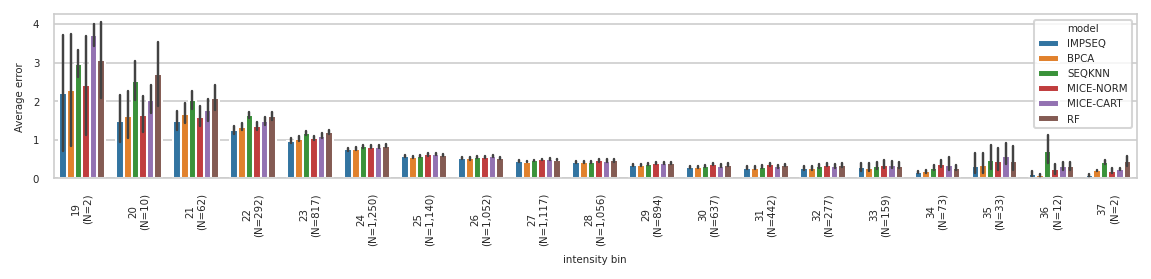

In [20]:
fig, ax = plt.subplots(figsize=(8, 2))
ax, errors_bind = vaep.plotting.errors.plot_errors_binned(
    val_pred_fake_na[top_5],
    ax=ax,
)
fname = args.out_figures / 'NAGuideR_errors_per_bin_val.png'
files_out[fname.name] = fname.as_posix()
vaep.savefig(ax.get_figure(), fname)

In [21]:
files_out

{'pred_val_BPCA.csv': 'runs/dev_dataset_small/proteinGroups_N50/preds/pred_val_BPCA.csv',
 'pred_test_BPCA.csv': 'runs/dev_dataset_small/proteinGroups_N50/preds/pred_test_BPCA.csv',
 'pred_real_na_BPCA.csv': 'runs/dev_dataset_small/proteinGroups_N50/preds/pred_real_na_BPCA.csv',
 'pred_val_COLMEDIAN.csv': 'runs/dev_dataset_small/proteinGroups_N50/preds/pred_val_COLMEDIAN.csv',
 'pred_test_COLMEDIAN.csv': 'runs/dev_dataset_small/proteinGroups_N50/preds/pred_test_COLMEDIAN.csv',
 'pred_real_na_COLMEDIAN.csv': 'runs/dev_dataset_small/proteinGroups_N50/preds/pred_real_na_COLMEDIAN.csv',
 'pred_val_IMPSEQ.csv': 'runs/dev_dataset_small/proteinGroups_N50/preds/pred_val_IMPSEQ.csv',
 'pred_test_IMPSEQ.csv': 'runs/dev_dataset_small/proteinGroups_N50/preds/pred_test_IMPSEQ.csv',
 'pred_real_na_IMPSEQ.csv': 'runs/dev_dataset_small/proteinGroups_N50/preds/pred_real_na_IMPSEQ.csv',
 'pred_val_IMPSEQROB.csv': 'runs/dev_dataset_small/proteinGroups_N50/preds/pred_val_IMPSEQROB.csv',
 'pred_test_IMPSEQ